<font size="6"> Demo notebook that imports .nwb file for Neuropixels recordings of the foraging task

<font size="4"> This notebook is independent of DataJoint. To see how the .nwb files were exported from the DataJoint pipeline, see [this notebook](https://github.com/hanhou/map-ephys/blob/export_foraging/notebook/han/Demo_export_nwb_foraging.ipynb).

# Preparation

## Download .nwb files from [Onedrive](https://1drv.ms/u/s!ApFywMwmT3mLlsF-rWNNdpBo9BwXUQ?e=iDcOxr)

## Prepare some util functions

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import h5py

def import_nwb_to_df(filename):
    with h5py.File(filename, mode='r') as f:
        g_trials = f['intervals']['trials']
        g_events = f['acquisition']['BehavioralEvents']
        g_electrodes = f['general']['extracellular_ephys']['electrodes']
        g_units = f['units']        
        
        df_trials = hdf_group_to_df(g_trials)
        dict_events = {key: g_events[key]['timestamps'][:] for key in g_events}

        df_units = hdf_group_to_df(g_units)
        df_electrodes = hdf_group_to_df(g_electrodes)
       
    # Add electrode info to units table
    df_units = df_units.merge(df_electrodes, left_on='electrodes', right_on='id')
    
    # Add hemisphere
    df_units['hemisphere'] = np.where(df_units['z'] <= 5739, 'left', 'right')
    
    return [df_trials, dict_events, df_units]

        
def hdf_group_to_df(group):
    '''
    Convert h5py group to dataframe
    '''
    
    tmp_dict = {}
    
    # Handle spike_times
    # see https://nwb-schema.readthedocs.io/en/latest/format_description.html#tables-and-ragged-arrays
    if 'spike_times' in group.keys():
        spike_times, spike_times_index = group['spike_times'], group['spike_times_index']
        unit_spike_times = []
        for i, idx in enumerate(spike_times_index):
            start_idx = 0 if i == 0 else spike_times_index[i - 1]
            unit_spike_times.append(spike_times[start_idx : idx])

        tmp_dict['spike_times'] = unit_spike_times

    # Other keys
    for key in group:
        if 'spike_times' in key: continue

        if isinstance(group[key][0], bytes):
            tmp_dict[key] = list(map(lambda x: x.decode(), group[key][:]))
        else:
            tmp_dict[key] = list(group[key][:])
        
    return pd.DataFrame(tmp_dict)


def moving_average(a, n=3) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_session_lightweight(data, fitted_data=None, smooth_factor=5, base_color='y', ax=None, vertical=False):
    # sns.reset_orig()

    with sns.plotting_context("notebook", font_scale=1):

        choice_history, reward_history, p_reward = data

        # == Fetch data ==
        n_trials = np.shape(choice_history)[1]

        p_reward_fraction = p_reward[1, :] / (np.sum(p_reward, axis=0))

        ignored_trials = np.isnan(choice_history[0])
        rewarded_trials = np.any(reward_history, axis=0)
        unrewarded_trials = np.logical_not(np.logical_or(rewarded_trials, ignored_trials))

        # == Choice trace ==
        fig = None
        if ax is None:  
            fig = plt.figure(figsize=(8, 3), dpi=200)
            ax = fig.add_subplot(111)
            fig.subplots_adjust(left=0.1, right=0.8, bottom=0.05, top=0.7)

        # Rewarded trials
        xx = np.nonzero(rewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, rewarded_trials] - 0.5) * 1.4
        ax.plot(*(xx, yy) if not vertical else [*(yy, xx)], 
                '|' if not vertical else '_', color='black', markersize=10, markeredgewidth=2)

        # Unrewarded trials
        xx = np.nonzero(unrewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, unrewarded_trials] - 0.5) * 1.4
        ax.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                '|' if not vertical else '_', color='gray', markersize=6, markeredgewidth=1)

        # Ignored trials
        xx = np.nonzero(ignored_trials)[0] + 1
        yy = [1.1] * sum(ignored_trials)
        ax.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                'x', color='red', markersize=2, markeredgewidth=0.5, label='ignored')

        # Base probability
        xx = np.arange(0, n_trials) + 1
        yy = p_reward_fraction
        ax.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                color=base_color, label='base rew. prob.', lw=1.5)

        # Smoothed choice history
        y = moving_average(choice_history, smooth_factor)
        x = np.arange(0, len(y)) + int(smooth_factor / 2) + 1
        ax.plot(*(x, y) if not vertical else [*(y, x)],
                linewidth=1.5, color='black', label='choice (smooth = %g)' % smooth_factor)

        # For each session, if any
        if fitted_data is not None:
            ax.plot(np.arange(0, n_trials), fitted_data[1, :], linewidth=1.5, label='model')

        ax.legend(fontsize=5, loc='upper left', bbox_to_anchor=(1, 1.3))
        
        if not vertical:
            ax.set_yticks([0, 1])
            ax.set_yticklabels(['Left', 'Right'])
        else:
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['Left', 'Right'])
    
    # ax.set_xlim(0,300)

    # fig.tight_layout()
    sns.despine(trim=True, ax=ax)

    return fig, ax

# Import data from nwb file

<font size="4"> As discussed in [this notebook](https://github.com/hanhou/map-ephys/blob/export_foraging/notebook/han/Demo_export_nwb_foraging.ipynb), there is a bug in NWB IO that we cannot reload nwb files using `pynwb` for now. The current workaround is using native `h5py`. <br> The imported data are stored in `df_trials`: , `dict_events`, and `df_units`

In [25]:
nwb_file_name = 'HH08_20210814_180826_s51.nwb'  # Change the path here

[df_trials, dict_events, df_units] = import_nwb_to_df(nwb_file_name)

In [8]:
df_trials

,auto_water,choice,early_lick,free_water,id,left_action_value,left_reward_prob,outcome,right_action_value,right_reward_prob,rpe,start_time,stop_time,task,task_protocol,trial,trial_instruction,trial_uid
0,0,right,early,0,0,0.000000,0.386,hit,2.696910e-01,0.064,1.000000,-0.9588,20.7430,foraging,100,1,none,42369
1,0,right,early,0,1,0.000000,0.386,miss,2.429110e-01,0.064,-0.269691,20.7430,31.5401,foraging,100,2,none,42370
2,0,right,early,0,2,0.000000,0.386,miss,2.187900e-01,0.064,-0.242911,31.5401,42.8290,foraging,100,3,none,42371
3,0,right,no early,0,3,0.000000,0.386,miss,1.970650e-01,0.064,-0.218790,42.8290,46.6594,foraging,100,4,none,42372
4,0,right,early,0,4,0.000000,0.386,miss,1.774960e-01,0.064,-0.197065,46.6594,54.2162,foraging,100,5,none,42373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,0,null,no early,0,602,NaN,0.400,ignore,NaN,0.050,NaN,4824.5059,4835.8139,foraging,100,603,none,42971
603,0,null,no early,0,603,NaN,0.400,ignore,NaN,0.050,NaN,4835.8139,4850.3581,foraging,100,604,none,42972
604,0,null,early,0,604,NaN,0.400,ignore,NaN,0.050,NaN,4850.3581,4868.0834,foraging,100,605,none,42973
605,0,left,no early,0,605,0.665139,0.400,hit,9.536130e-21,0.050,0.458519,4868.0834,4882.4514,foraging,100,606,none,42974


In [9]:
dict_events.keys()

dict_keys(['choice', 'go', 'left_lick', 'lickportready', 'reward', 'right_lick', 'trialend'])

In [10]:
df_units

,spike_times,amplitude_cutoff,avg_firing_rate,cumulative_drift,d_prime,drift_metric,duration,electrodes,electrodes_index,halfwidth,...,rel_x,rel_y,rel_z,shank,shank_col,shank_row,x,y,z,hemisphere
0,"[-4.656868508302933, -4.567168472829559, -4.56...",0.003084,11.780700,86.16,7.26461,NaN,0.439531,4,1,0.178560,...,16.0,40.0,NaN,1,1,3,4680.0,5280.0,6918.0,right
1,"[-4.5675351396412305, -4.256668350037111, -3.2...",0.044188,5.071050,59.37,3.85977,NaN,0.453267,14,2,0.192295,...,0.0,140.0,NaN,1,1,8,4640.0,5160.0,6938.0,right
2,"[-0.7842336434715986, -0.6033335719316506, 19....",0.000806,0.975709,56.55,10.99970,NaN,0.370854,30,3,0.137353,...,0.0,300.0,NaN,1,1,16,4540.0,5000.0,6958.0,right
3,"[65.80529269046642, 125.74621639510372, 161.24...",0.001093,2.097270,50.87,8.45956,NaN,0.508208,30,4,0.137353,...,0.0,300.0,NaN,1,1,16,4540.0,5000.0,6958.0,right
4,"[-3.9794349070671915, -1.9105007555393656, -0....",0.015264,5.308380,349.05,6.44183,NaN,0.137353,33,5,0.096147,...,48.0,320.0,NaN,1,2,17,4520.0,4980.0,6958.0,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,"[-4.603858823671945, -4.5085916295362285, -4.4...",0.002234,5.346120,1435.94,6.73611,NaN,0.164825,947,-105,0.109883,...,32.0,1335.0,NaN,1,2,90,3820.0,2840.0,6298.0,right
152,"[-4.257290238147438, -4.231890097513633, -0.40...",0.002305,1.340230,259.46,9.29820,NaN,0.824125,968,-104,0.164825,...,0.0,1500.0,NaN,1,1,101,3680.0,2680.0,6298.0,right
153,"[-2.2591125081035277, -0.271168168052502, -0.0...",0.007241,0.468787,315.25,6.71674,NaN,0.563152,1014,-103,0.164825,...,0.0,1845.0,NaN,1,1,124,3400.0,2320.0,6318.0,right
154,"[6.952271826208496, 7.934143929239164, 58.3711...",0.013382,0.148284,95.83,5.94354,NaN,0.219767,785,-102,0.096148,...,32.0,120.0,NaN,1,2,9,5120.0,4000.0,6398.0,right


In [14]:
df_units.keys()

Index(['spike_times', 'amplitude_cutoff', 'avg_firing_rate',
       'cumulative_drift', 'd_prime', 'drift_metric', 'duration', 'electrodes',
       'electrodes_index', 'halfwidth', 'id_x', 'insertion_number',
       'isi_violation', 'isolation_distance', 'l_ratio', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'presence_ratio', 'pt_ratio',
       'recovery_slope', 'repolarization_slope', 'sampling_rate',
       'silhouette_score', 'spread', 'unit_amp', 'unit_id', 'unit_posx',
       'unit_posy', 'unit_quality', 'unit_snr', 'velocity_above',
       'velocity_below', 'waveform_mean', 'waveform_sd', 'ccf_annotation',
       'electrode_id', 'filtering', 'group', 'group_name', 'id_y', 'imp',
       'location', 'rel_x', 'rel_y', 'rel_z', 'shank', 'shank_col',
       'shank_row', 'x', 'y', 'z', 'hemisphere'],
      dtype='object')

# Plot foraging behavior of this session

(<Figure size 1600x600 with 1 Axes>, <AxesSubplot:>)

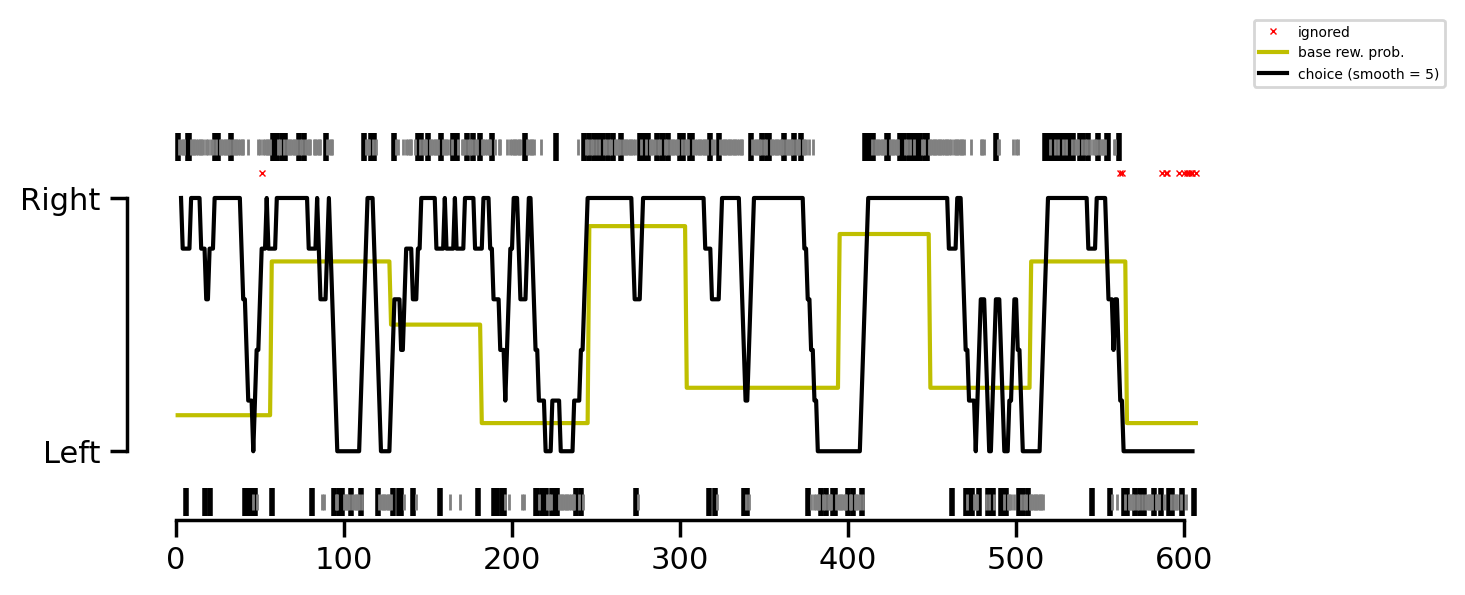

In [15]:
# Reformat data
_choice_history = df_trials.choice.values
choice_history = np.array([{'left': 0, 'right': 1, 'null': np.nan}[c] for c in _choice_history])

_reward = df_trials.outcome
reward_history = np.zeros([2, len(_reward)])  # .shape = (2, N trials)
for c in (0, 1):
    reward_history[c, choice_history==c] = (_reward[choice_history==c] == 'hit').astype(int)
    
p_reward = np.vstack([df_trials.left_reward_prob, df_trials.right_reward_prob])

# Plot session
plot_session_lightweight([np.array([choice_history]), reward_history, p_reward])

# Plot events and spikes

Plot an excerpt of ephys recording (between `t_start` and `t_end`)

In [16]:
dict_events['left_lick']

array([  14.59282,   14.74819,   15.67032, ..., 4875.30442, 4875.43699,
       4875.60347])

[(-5.0, 200.0), Text(0.5, 0, 'time (sec)'), Text(0, 0.5, 'unit #')]

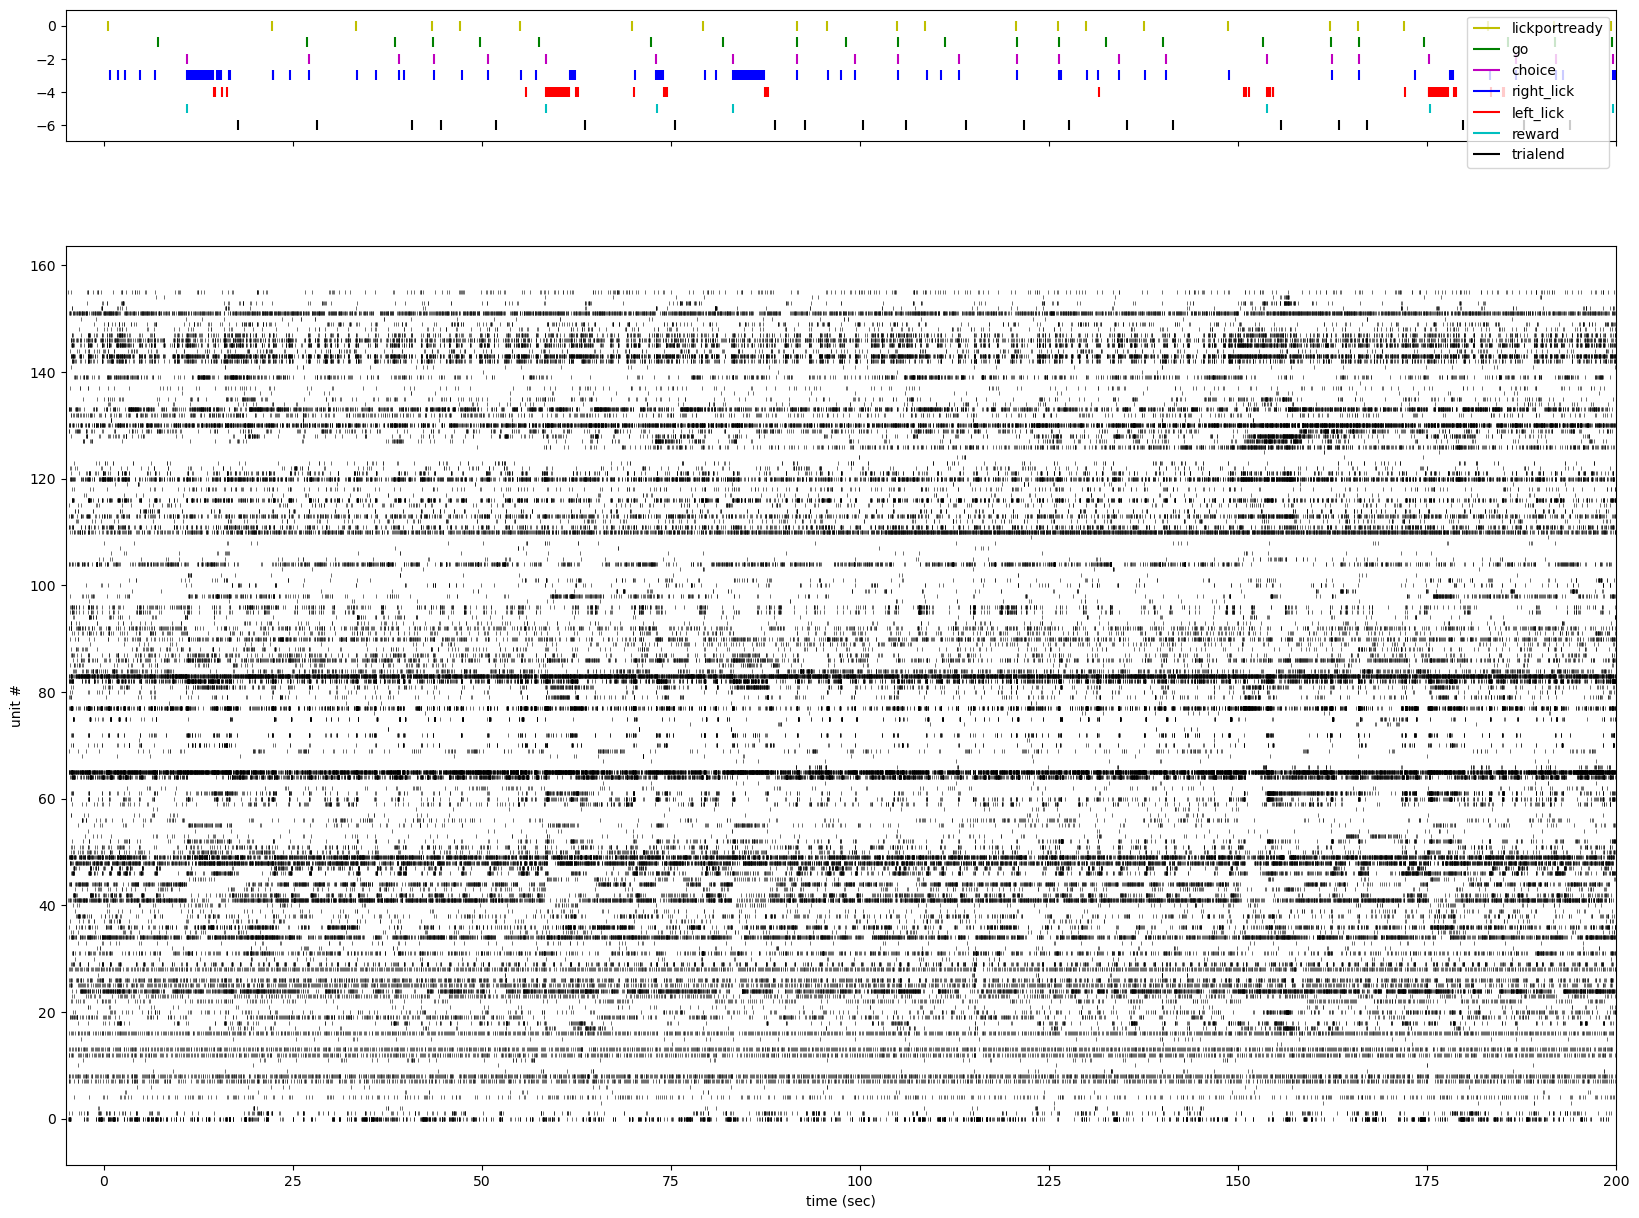

In [17]:
t_start, t_end = -5, 200

spike_times = df_units.spike_times
spike_times = [x[(x > t_start)&(x < t_end)] for x in spike_times]

event_color_map = {'lickportready': 'y', 'go': 'g', 'choice': 'm', 'right_lick': 'b', 'left_lick': 'r', 'reward': 'c', 'trialend': 'k'}
event_times = [dict_events[x][(dict_events[x] > t_start) & (dict_events[x] < t_end)] for x in event_color_map]

fig = plt.figure(figsize=(20, 15))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 7]})

axs[1].eventplot(spike_times, colors='black', lineoffsets=1, linelengths=0.8, lw=0.4)
axs[0].eventplot(event_times, colors=list(event_color_map.values()), linelengths=0.6, lineoffsets=-1)

axs[0].legend(event_color_map)
axs[1].set(xlim=(t_start, t_end), xlabel='time (sec)', ylabel='unit #')

# Get CCF location of each unit

`x`, `y`, `z` are in [CCF coordinates](http://help.brain-map.org/display/mousebrain/api)

In [18]:
df_units[['x', 'y', 'z', 'hemisphere', 'ccf_annotation']]

,x,y,z,hemisphere,ccf_annotation
0,4680.0,5280.0,6918.0,right,"anterior commissure, olfactory limb"
1,4640.0,5160.0,6938.0,right,Nucleus accumbens
2,4540.0,5000.0,6958.0,right,Caudoputamen
3,4540.0,5000.0,6958.0,right,Caudoputamen
4,4520.0,4980.0,6958.0,right,Caudoputamen
...,...,...,...,...,...
151,3820.0,2840.0,6298.0,right,"Prelimbic area, layer 5"
152,3680.0,2680.0,6298.0,right,"Prelimbic area, layer 5"
153,3400.0,2320.0,6318.0,right,"Anterior cingulate area, dorsal part, layer 5"
154,5120.0,4000.0,6398.0,right,"Lateral septal nucleus, rostral (rostroventral..."


Number of units per area

In [19]:
df_units.groupby(['hemisphere', 'ccf_annotation'])['hemisphere'].count()

hemisphere  ccf_annotation                                      
left        Anterior cingulate area, dorsal part, layer 5            1
            Lateral septal nucleus, rostral (rostroventral) part    16
            Prelimbic area, layer 6a                                 5
            Secondary motor area, layer 2/3                          3
            Secondary motor area, layer 5                            3
            Striatum                                                 3
right       Anterior cingulate area, dorsal part, layer 5            1
            Anterior cingulate area, ventral part, layer 5           1
            Caudoputamen                                            40
            Lateral septal nucleus, rostral (rostroventral) part    10
            Nucleus accumbens                                        1
            Prelimbic area, layer 5                                  2
            Secondary motor area, layer 2/3                          6
            

Units of this session came from three probes

In [20]:
df_units['group_name'].unique()

array(['18005108622 1-384', '18005123491 1-384', '19122505354 1-384'],
      dtype=object)

Plot units in CCF coordinate

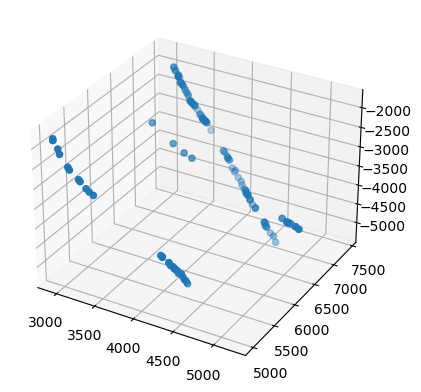

In [21]:
from mpl_toolkits import mplot3d

fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

ax.scatter3D(df_units.x, df_units.z, -df_units.y)